# Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.


# Описание данных

Каждая запись в логе — это действие пользователя, или событие. 

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Изучение общей информации

In [21]:
import pandas as pd
import datetime as dt
from scipy import stats as st
import numpy as np
import math as mth

In [22]:
logs_exp = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
logs_exp.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Подготовка данных

In [23]:
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [24]:
# Проверка на пропуски
logs_exp.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [25]:
# Проверка на дубликаты
logs_exp.duplicated().sum()

413

In [26]:
logs_exp = logs_exp.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_id',\
                                   'EventTimestamp': 'event_timestamp', 'ExpId': 'group_id'})
logs_exp.head()

,event_name,user_id,event_timestamp,group_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [27]:
# Добавление столбца даты и времени и столбца дат
logs_exp['datetime'] = pd.to_datetime(logs_exp['event_timestamp'], unit='s')
logs_exp['date'] = logs_exp['datetime'].dt.date
logs_exp.head()

,event_name,user_id,event_timestamp,group_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [28]:
# Удаляем дубликаты
logs_exp = logs_exp.drop_duplicates().reset_index(drop=True)

## Изучение и проверка данных

In [29]:
# Сколько всего событий в логе?
events_count = logs_exp['event_name'].count()
events_count

243713

In [30]:
# Сколько всего пользователей в логе?
users_count = logs_exp['user_id'].nunique()
users_count

7551

In [31]:
# Сколько в среднем событий приходится на пользователя?
logs_exp.groupby('user_id').agg({'event_name': 'count'}).mean()

event_name    32.275593
dtype: float64

In [32]:
# Данными за какой период вы располагаете?
display(logs_exp['date'].max())
display(logs_exp['date'].min())

datetime.date(2019, 8, 7)

datetime.date(2019, 7, 25)

25 июля - 7 августа 2019

<AxesSubplot:>

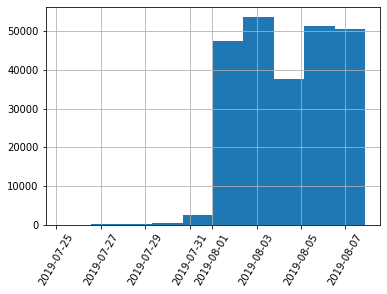

In [33]:
# Гистограмма по дате и времени
logs_exp['datetime'].hist(xrot=60)

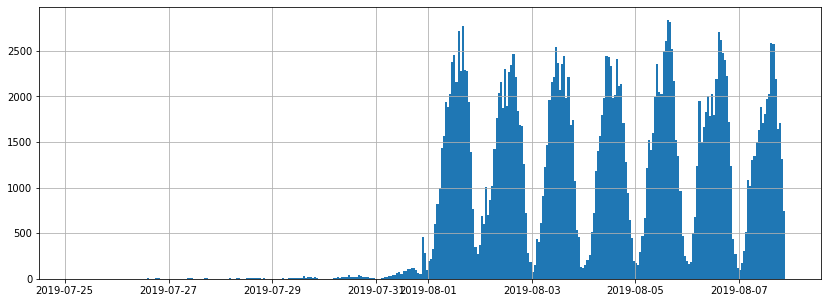

In [34]:
# код ревьюера
logs_exp['datetime'].hist(bins=14*24, figsize=(14, 5));

Можно ли быть уверенным, что у вас одинаково полные данные за весь период? 

Ответ: Быть уверенным, что наблюдаются одинаково полные данные за весь период, нельзя, так как мы видим "перекос данных" в сторону первой недели августа(технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого).

In [35]:
# Оставляем только полные данные
logs_exp = logs_exp[logs_exp['date'] >= dt.date(2019, 8, 1)]

In [36]:
# Данными за какой период времени вы располагаете на самом деле?
display(logs_exp['date'].max())
display(logs_exp['date'].min())

datetime.date(2019, 8, 7)

datetime.date(2019, 8, 1)

1-7 августа 2019

In [55]:
# Много ли событий и пользователей вы потеряли, отбросив старые данные?
# В начале шага 3 мы считали количество событий и пользователей.
# Они равняются соответственно 243713 и 7551.
# Посчитаем, сколько событий и пользователей мы потеряли.

display('Абсолютная разница количества потерянных событий', events_count - logs_exp['event_name'].count())
display('Абсолютная разница количества потерянных пользователей', users_count - logs_exp['user_id'].nunique())

display('Относительная разница количества потерянных событий в процентах', (1 - logs_exp['event_name'].count() / events_count).round(3) * 100)
display('Относительная разница количества потерянных пользователей в процентах', round((1 - logs_exp['user_id'].nunique() / users_count), 3) * 100)

'Абсолютная разница количества потерянных событий'

2826

'Абсолютная разница количества потерянных пользователей'

17

'Относительная разница количества потерянных событий в процентах'

1.2

'Относительная разница количества потерянных пользователей в процентах'

0.2

In [56]:
# Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.
logs_exp['group_id'].unique()

array([246, 247, 248])

## Изучение воронки событий

In [57]:
# Посмотрите, какие события есть в логах, как часто они встречаются. 
# Отсортируйте события по частоте.
logs_exp['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [58]:
# Посчитайте, сколько пользователей совершали каждое из этих событий.
# Отсортируйте события по числу пользователей.
events_users = logs_exp.groupby('event_name', as_index=False).agg({'user_id': 'nunique'})\
.sort_values(by='user_id', ascending=False).rename(columns={'user_id': 'users_count'})
events_users

,event_name,users_count
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [59]:
# Посчитайте долю пользователей, которые хоть раз совершали событие.
users_count = logs_exp['user_id'].nunique()
events_users['share_users'] = (events_users['users_count'].div(users_count) * 100).round(2)
events_users

,event_name,users_count,share_users
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Предположите, в каком порядке происходят события. 

Ответ: Вероятно, порядок событий такой: Tutorial -> MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful

Все ли они выстраиваются в последовательную цепочку?

Ответ: Нет. Может не быть события Tutorial, если пользователь пропускает его и сразу переходит на главный экран.
(Tutorial по условию можно не учитывать при расчёте воронки)

In [60]:
# По воронке событий посчитайте, какая доля пользователей проходит 
# на следующий шаг воронки (от числа пользователей на предыдущем).
events_users = events_users.drop(4)
events_users['conversion_per_step'] = (events_users['users_count']/(events_users['users_count']).shift()).round(2) * 100
events_users

,event_name,users_count,share_users,conversion_per_step
1,MainScreenAppear,7419,98.47,NaN
2,OffersScreenAppear,4593,60.96,62.0
0,CartScreenAppear,3734,49.56,81.0
3,PaymentScreenSuccessful,3539,46.97,95.0


На каком шаге теряете больше всего пользователей?

Ответ: Больше всего пользователей теряем при переходе с MainScreenAppear на OffersScreenAppear.

In [61]:
# Какая доля пользователей доходит от первого события до оплаты?
(events_users.loc[3, 'users_count']/events_users.loc[1, 'users_count']).round(2) * 100

48.0

48% пользователей доходит от первого события до оплаты

## Изучение результатов эксперимента

In [62]:
# Сколько пользователей в каждой экспериментальной группе?
users_count_by_groups = logs_exp.groupby('group_id', as_index=False).agg({'user_id': 'nunique'})\
.rename(columns={'user_id': 'users_count'})
users_count_by_groups

,group_id,users_count
0,246,2484
1,247,2513
2,248,2537


H_0: Доли пользователей, совершивших определенное событие, не имеют значимой разницы.

H_1: Доли пользователей, совершивших определенное событие, являются разными.

In [63]:
# Выберите самое популярное событие. 
# Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп.
exp_AA = logs_exp.query('group_id == [246, 247] and event_name == "MainScreenAppear"')
exp_AA = exp_AA.groupby(by=['group_id', 'event_name'], as_index=False).agg({'user_id': 'nunique'})\
.rename(columns={'user_id': 'users_count_by_event'})
exp_AA

,group_id,event_name,users_count_by_event
0,246,MainScreenAppear,2450
1,247,MainScreenAppear,2476


In [64]:
# Посчитайте долю пользователей, совершивших это событие. 
exp_AA = exp_AA.merge(users_count_by_groups, on='group_id', how='inner')
exp_AA['users_share'] = (exp_AA['users_count_by_event']/exp_AA['users_count']).round(3) * 100
exp_AA

,group_id,event_name,users_count_by_event,users_count,users_share
0,246,MainScreenAppear,2450,2484,98.6
1,247,MainScreenAppear,2476,2513,98.5


In [66]:
#  Проделайте то же самое для всех других событий 
# (удобно обернуть проверку в отдельную функцию).

def check(data, groups, alpha):
    users_count_by_groups = data.groupby('group_id', as_index=False)\
    .agg({'user_id': 'nunique'})\
    .rename(columns={'user_id': 'users_count'})

    events_list = data['event_name'].unique()
        
    for event in events_list:
        if event == 'Tutorial':
            continue
            
        exp = data.query('group_id == @groups and event_name == @event')
        exp = exp.groupby(by=['group_id', 'event_name'], as_index=False)\
        .agg({'user_id': 'nunique'})\
        .rename(columns={'user_id': 'users_count_by_event'})   
    
        exp = exp.merge(users_count_by_groups, on='group_id', how='inner')
        exp['users_share'] = (exp['users_count_by_event']/exp['users_count'])\
        .round(3) * 100

        success1 = exp['users_count_by_event'].values[0]
        success2 = exp['users_count_by_event'].values[1]
        
        trial1 = exp['users_count'].values[0]
        trial2 = exp['users_count'].values[1]
        
        if len(groups) == 3:
            success3 = exp['users_count_by_event'].values[2]
            trial3 = exp['users_count'].values[2]
            successes = np.array([success1+success2, success3])
            trials = np.array([trial1+trial2, trial3])
        else:
            successes = np.array([success1, success2])
            trials = np.array([trial1, trial2])

        # пропорция успехов в первой группе:
        p1 = successes[0]/trials[0]

        # пропорция успехов во второй группе:
        p2 = successes[1]/trials[1]

        # пропорция успехов в комбинированном датасете:
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

        # разница пропорций в датасетах
        difference = p1 - p2

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('p-значение: ', p_value)

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
            ) 


In [67]:
alpha = .05  # критический уровень статистической значимости

In [68]:
# A/A-testing
groups = [246, 247]
check(logs_exp, groups, alpha)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Можно ли сказать, что разбиение на группы работает корректно?

Ответ: Разбиение на группы работает корректно, так как A/A-тест показал, что значимой разницы между долями нет.

In [69]:
# A/B-testing
groups = [246, 248]
check(logs_exp, groups, alpha)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [70]:
# A/B-testing
groups = [247, 248]
check(logs_exp, groups, alpha)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [71]:
# A/B-testing: 246 и 247 объединяем в одну A-группу
groups = [246, 247, 248]
check(logs_exp, groups, alpha)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Какие выводы из эксперимента можно сделать?

Ответ: Результаты A/A/B-эксперимента показали, что значимой разницы между долями пользователей с новыми и старыми шрифтами нет. Поэтому опасения менеджеров о том, что пользователям будет непривычно при изменении шрифтов во всём приложении, не оправдались. Можно смело менять шрифты либо оставить прежние.

Какой уровень значимости вы выбрали при проверке статистических гипотез выше? 

Ответ: При проверке статистических гипотез выше было выбрано значение alpha = 0.05 .

Посчитайте, сколько проверок статистических гипотез вы сделали. 

Ответ: Было сделано 16 проверок.

При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? 

Ответ: Можно использовать метод Бонферрони. Тогда согласно этому методу необходимо разделить alpha на 16, так как было произведено 16 сравнений.

Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

In [72]:
# Изменим метод check, скорректировав значение alpha согласно методу Бонферрони
def check(data, groups, aplha):
    users_count_by_groups = data.groupby('group_id', as_index=False)\
    .agg({'user_id': 'nunique'})\
    .rename(columns={'user_id': 'users_count'})

    events_list = data['event_name'].unique()
    
    bonferroni_alpha = alpha / 16
    
    for event in events_list:
        if event == 'Tutorial':
            continue
            
        exp = data.query('group_id == @groups and event_name == @event')
        exp = exp.groupby(by=['group_id', 'event_name'], as_index=False)\
        .agg({'user_id': 'nunique'})\
        .rename(columns={'user_id': 'users_count_by_event'})   
    
        exp = exp.merge(users_count_by_groups, on='group_id', how='inner')
        exp['users_share'] = (exp['users_count_by_event']/exp['users_count'])\
        .round(3) * 100

        success1 = exp['users_count_by_event'].values[0]
        success2 = exp['users_count_by_event'].values[1]
        
        trial1 = exp['users_count'].values[0]
        trial2 = exp['users_count'].values[1]
        
        if len(groups) == 3:
            success3 = exp['users_count_by_event'].values[2]
            trial3 = exp['users_count'].values[2]
            successes = np.array([success1+success2, success3])
            trials = np.array([trial1+trial2, trial3])
        else:
            successes = np.array([success1, success2])
            trials = np.array([trial1, trial2])

        # пропорция успехов в первой группе:
        p1 = successes[0]/trials[0]

        # пропорция успехов во второй группе:
        p2 = successes[1]/trials[1]

        # пропорция успехов в комбинированном датасете:
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

        # разница пропорций в датасетах
        difference = p1 - p2

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('p-значение: ', p_value)

        if p_value < bonferroni_alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
            ) 

In [73]:
# A/A-testing
groups = [246, 247]
check(logs_exp, groups, alpha)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [74]:
# A/B-testing
groups = [246, 248]
check(logs_exp, groups, alpha)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [75]:
# A/B-testing
groups = [247, 248]
check(logs_exp, groups, alpha)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [76]:
# A/B-testing: 246 и 247 объединяем в одну A-группу
groups = [246, 247, 248]
check(logs_exp, groups, alpha)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Выводы из эксперимента остались прежними.

## Общий вывод по проекту

Проделанная работа и полученные результаты:

1. Изучена общая информация из файла /datasets/logs_exp.csv .

2. Подготовлены данные:
- заменены названия столбцов
- проверено наличие пропусков и дубликатов
- изменены типы данных
- добавлены новые столбцы данных в датасет

3. Изучены и проверены данные:
- рассчитаны количество событий(243713) и пользователей(7551) в логе
- вычислено, сколько в среднем событий приходится на пользователя(32)
- выяснено, данными за какой период времени мы располагаем на самом деле(1-7 августа 2019)
- вычислено, сколько событий и пользователей мы потеряли, отбросив старые данные(событий -- 2826 или 1,2%; пользователей -- 17 или 0,2%)
- проверено, что у нас есть пользователи из всех трёх экспериментальных групп

4. Изучена воронка событий:
- выяснено, какие события есть в логах, как часто они встречаются:

  Главный экран           117328
  
  Экран предложений       46333
  
  Корзина                 42303

  Экран оплаты            33918

  Справка                 1005
  
- вычислено, сколько пользователей совершали каждое из этих событий и отсортированы события по числу пользователей:

  Главный экран	7419
  
  Экран предложений	4593
  
  Корзина	3734
  
  Экран оплаты	3539
  
  Справка	840

- рассчитаны доли пользователей, которые хоть раз совершали событие:

  Главный экран	98.47
  
  Экран предложений	60.96
  
  Корзина	49.56
  
  Экран оплаты	46.97
  
  Справка		11.15
  
- предположен порядок событий: Справка -> Главный экран -> Экран предложений -> Корзина -> Экран оплаты . Они не обязательно выстраиваются в последовательную цепочку. Ни один из шагов воронки не является обязательным. На сайт можно прийти из поисковой строки, рассылки или пуш-уведомления. Также товар в корзину можно отправить с главного экрана и т. д. 

- рассчитана, какая доля пользователей(в процентах) проходит на следующий шаг воронки (от числа пользователей на предыдущем): 
 
  Главный экран -> Экран предложений -- 62%

  Экран предложений -> Корзина -- 81%

  Корзина -> Экран оплаты -- 95%

- выяснено, на каком шаге теряем больше всего пользователей: при переходе с главного экрана на экран предложений

- выяснено, какая доля пользователей доходит от первого события до оплаты: 48%

5. Изучены результаты эксперимента:

   Было проведено A/A/B-тестирование. 
   
- вычислено, сколько пользователей в каждой экспериментальной группе:

  контрольная группа1 со старыми шрифтами -- 2484
  
  контрольная группа2 со старыми шрифтами -- 2513
  
  группа с новыми шрифтами -- 2537
  
- была создана функция, которая сравнивает результаты тестирования группы с новыми шрифтами с каждой из контрольных групп в отдельности по каждому событию, а также сравнивает результаты тестирования с объединённой контрольной группой(контрольная группа1+контрольная группа2); также проведено сравнение результатов между контрольными группами; всего осуществлено 16 сравнений и получены следующие выводы:

  1. Разбиение на группы работает корректно, так как A/A-тест показал, что значимой разницы между долями нет.

  2. Результаты A/A/B-эксперимента показали, что значимой разницы между долями пользователей с новыми и старыми шрифтами нет. Поэтому опасения менеджеров о том, что пользователям будет непривычно при изменении шрифтов во всём приложении, не оправдались. Можно смело менять шрифты либо оставить прежние.
  
  
  
Рекомендации:

1. Изменить шрифты во всем приложении можно. Данное изменение никак не отразится на поведении пользователей.

2. Стоит обратить особое внимание на конверсию перехода с главного экрана на экран предложений, так как на этом шаге мы теряем больше всего пользователей.

3. Учитывая, что 48% пользователей доходит от первого события до оплаты, необходимо также обратить внимание и на другие шаги воронки с целью увеличения этого показателя.
